  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
Using cached gymnasium-1.1.1-py3-none-any.whl (965 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gymnasium-robotics 1.3.1 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.c

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FetchSlide-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FetchSlide-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FetchPickAndPlace-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FetchPickAndPlace-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py

Initial tensordict: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([45]), device=cpu, dtype=torch.float64, is_shared=False),
        pixels: Tensor(shape=torch.Size([480, 480, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)
Example cumulative reward: 884.10


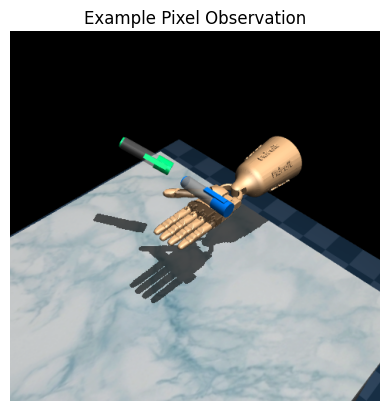

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

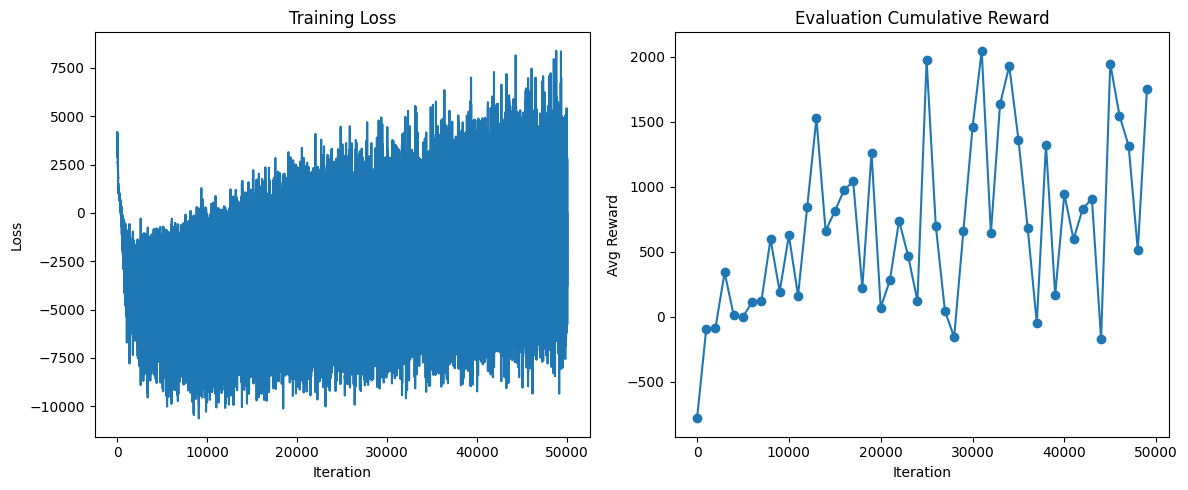

Final Average Cumulative Reward over 100 episodes: 773.74
Viewer Rollout Cumulative Reward: 223.88
Moviepy - Building video /content/results_video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/results_video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/results_video/rl-video-episode-0.mp4


In [1]:
# Install dependencies (make sure to run this in a Colab cell)
!pip install torchrl matplotlib minari gymnasium-robotics
!pip uninstall gymnasium -y
!pip install gymnasium==0.29.1

!sudo apt-get update
!sudo apt-get install -y python3-opengl ffmpeg xvfb
!pip install pyvirtualdisplay

# Imports and seed setting
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchrl
import gymnasium
from pyvirtualdisplay import Display
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs import DoubleToFloat, TransformedEnv
from torchrl.data.datasets.minari_data import MinariExperienceReplay
from torchrl.data.replay_buffers import SamplerWithoutReplacement
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.envs.utils import ExplorationType, set_exploration_type
from torchrl.modules import MLP, ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import IQLLoss, SoftUpdate
from torchrl.trainers.helpers.models import ACTIVATIONS
from tqdm.auto import tqdm
from gymnasium.utils.save_video import save_video
from base64 import b64encode
from IPython.display import HTML

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
warnings.simplefilter("ignore")

# Start a virtual display (needed for rendering in Colab)
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# ------------------------- Environment Setup -------------------------
env_id = "AdroitHandPen-v1"

# Create an example environment to inspect initial observations and pixels
example_env = GymEnv(env_id, from_pixels=True, pixels_only=False)
example_env.set_seed(seed)
init_td = example_env.reset()
print("Initial tensordict:", init_td)
max_episode_steps = 1000
td_example = example_env.rollout(max_steps=max_episode_steps, auto_cast_to_device=True)
print(f"Example cumulative reward: {td_example['next', 'reward'].sum():.2f}")
plt.imshow(td_example["pixels"][0].numpy())
plt.title("Example Pixel Observation")
plt.axis("off")
plt.show()

# Create training/evaluation environment (with proper device handling)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_env = GymEnv(env_id, device=device)
env = TransformedEnv(base_env, DoubleToFloat())
env.set_seed(seed)

# ------------------------- Offline Dataset Setup -------------------------
dataset_id = "D4RL/pen/human-v2"
batch_size = 256
replay_buffer = MinariExperienceReplay(
    dataset_id,
    split_trajs=False,
    batch_size=batch_size,
    sampler=SamplerWithoutReplacement(),
    transform=DoubleToFloat(),
)

# ------------------------- Network & IQL Model Setup -------------------------
hidden_sizes = [128, 128]
activation_fn = ACTIVATIONS["relu"]

# Value network (V(s))
value_net = MLP(num_cells=hidden_sizes, out_features=1, activation_class=activation_fn)
value_net = ValueOperator(in_keys=["observation"], out_keys=["state_value"], module=value_net)

# Q-network (Q(s,a))
q_net = MLP(num_cells=hidden_sizes, out_features=1, activation_class=activation_fn)
qvalue = ValueOperator(in_keys=["observation", "action"], out_keys=["state_action_value"], module=q_net)

# Actor/policy network (π(a|s))
action_spec = env.action_spec
actor_mlp = MLP(num_cells=hidden_sizes, out_features=2 * action_spec.shape[-1], activation_class=activation_fn)
actor_extractor = NormalParamExtractor(scale_lb=0.1)
actor_net = torch.nn.Sequential(actor_mlp, actor_extractor)
actor_module = TensorDictModule(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])
actor = ProbabilisticActor(
    module=actor_module,
    in_keys=["loc", "scale"],
    spec=action_spec,
    distribution_class=TanhNormal,
    distribution_kwargs={"tanh_loc": False},
    default_interaction_type=ExplorationType.DETERMINISTIC,
)

# Combine the three modules into one model list and move to the correct device
model = torch.nn.ModuleList([actor, qvalue, value_net]).to(device)

# Ensure the models run by forwarding a sample tensordict
with torch.no_grad(), set_exploration_type(ExplorationType.RANDOM):
    td_eval = env.reset().to(device)
    for net in model:
        net(td_eval)

# IQL loss and target network update
loss_module = IQLLoss(actor, qvalue, value_network=value_net,
                      loss_function="l2", temperature=3, expectile=0.7)
loss_module.make_value_estimator(gamma=0.99)
target_net_updater = SoftUpdate(loss_module, tau=0.005)
optimizer = torch.optim.Adam(loss_module.parameters(), lr=0.0003)

# ------------------------- Evaluation Function -------------------------
@torch.no_grad()
def evaluate_policy(env, policy, num_eval_episodes=20):
    rewards = []
    for _ in range(num_eval_episodes):
        eval_td = env.rollout(max_steps=max_episode_steps, policy=policy, auto_cast_to_device=True)
        rewards.append(eval_td["next", "reward"].sum().item())
    return np.mean(rewards)

# ------------------------- Training Loop -------------------------
iterations = 50000    # Total training iterations
eval_interval = 1000  # Frequency of evaluation
loss_logs = []
eval_reward_logs = []

pbar = tqdm(range(iterations), desc="Training")
for i in pbar:
    # Sample a batch from the offline dataset
    data = replay_buffer.sample()
    loss_dict = loss_module(data.to(device))
    loss = loss_dict["loss_value"] + loss_dict["loss_qvalue"] + loss_dict["loss_actor"]
    loss_logs.append(loss.item())

    # Backpropagation step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    target_net_updater.step()

    # Evaluation at intervals
    if i % eval_interval == 0:
        avg_reward = evaluate_policy(env, actor)
        eval_reward_logs.append(avg_reward)
        pbar.set_description(f"Iter {i} | Loss: {loss_logs[-1]:.2f} | Eval Return: {avg_reward:.2f}")
pbar.close()

# ------------------------- Plot Training Metrics -------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(loss_logs)
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")
axes[1].plot(np.arange(0, iterations, eval_interval), eval_reward_logs, marker="o")
axes[1].set_title("Evaluation Cumulative Reward")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Avg Reward")
plt.tight_layout()
plt.show()

# Final evaluation over 100 episodes
final_score = evaluate_policy(env, actor, num_eval_episodes=100)
print(f"Final Average Cumulative Reward over 100 episodes: {final_score:.2f}")

# ------------------------- Rollout Visualization -------------------------
viewer_env = TransformedEnv(
    GymEnv(env_id, from_pixels=True, pixels_only=False),
    DoubleToFloat()
)
viewer_env.set_seed(seed)
td_view = viewer_env.rollout(max_steps=max_episode_steps, policy=actor, auto_cast_to_device=True)
print(f"Viewer Rollout Cumulative Reward: {td_view['next', 'reward'].sum():.2f}")

# Save rollout as video
frames = list(td_view["pixels"].numpy())
os.makedirs("results_video", exist_ok=True)
save_video(frames, video_folder="results_video", fps=30)

# Display the video inline (Colab-compatible)
mp4 = open("results_video/rl-video-episode-0.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video controls style='margin: auto; display: block'>
    <source src='{data_url}' type='video/mp4'>
</video>
""")


In [2]:
# Add-on: Save experiment results for later comparison
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def save_experiment_results(
    variant_name: str,
    loss_logs: list,
    eval_reward_logs: list,
    final_score: float,
    video_path: str,
    eval_interval: int,
    base_dir: str = "saved_results",
):
    """
    Save training curves, logs, final score, and rollout video to a timestamped folder.

    Args:
        variant_name: a short name for this run/variant (e.g. "hyperbolic_iql")
        loss_logs: list of training losses
        eval_reward_logs: list of eval rewards recorded every `eval_interval` iters
        final_score: final average cumulative reward
        video_path: path to the .mp4 rollout video
        eval_interval: interval (in iterations) between successive evals
        base_dir: root directory to store all experiments
    """
    # 1. Create a timestamped results directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join(base_dir, f"{variant_name}_{timestamp}")
    os.makedirs(save_dir, exist_ok=True)

    # 2. Save raw logs as NumPy arrays
    np.save(os.path.join(save_dir, "loss_logs.npy"), np.array(loss_logs))
    np.save(os.path.join(save_dir, "eval_reward_logs.npy"), np.array(eval_reward_logs))

    # 3. Save CSV of evaluation rewards
    import pandas as pd
    iterations = np.arange(0, eval_interval * len(eval_reward_logs), eval_interval)
    df = pd.DataFrame({
        "iteration": iterations,
        "eval_reward": eval_reward_logs
    })
    df.to_csv(os.path.join(save_dir, "eval_rewards.csv"), index=False)

    # 4. Plot and save the training loss curve
    plt.figure()
    plt.plot(loss_logs)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "loss_curve.png"))
    plt.close()

    # 5. Plot and save the evaluation reward curve
    plt.figure()
    plt.plot(iterations, eval_reward_logs, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Eval Reward")
    plt.title("Evaluation Reward")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "reward_curve.png"))
    plt.close()

    # 6. Save final score to JSON
    with open(os.path.join(save_dir, "final_score.json"), "w") as f:
        json.dump({"final_score": final_score}, f, indent=2)

    # 7. Copy the rollout video
    if os.path.isfile(video_path):
        shutil.copy(video_path, os.path.join(save_dir, os.path.basename(video_path)))

    print(f"✅ Results saved to {save_dir}")

# Example usage (call after training & video generation):
save_experiment_results(
    variant_name="hyperbolic_iql",
    loss_logs=loss_logs,
    eval_reward_logs=eval_reward_logs,
    final_score=final_score,
    video_path="results_video/rl-video-episode-0.mp4",
    eval_interval=eval_interval,
)

✅ Results saved to saved_results/hyperbolic_iql_20250413_121923


Loading latest run: vanilla_iql_20250413_121923


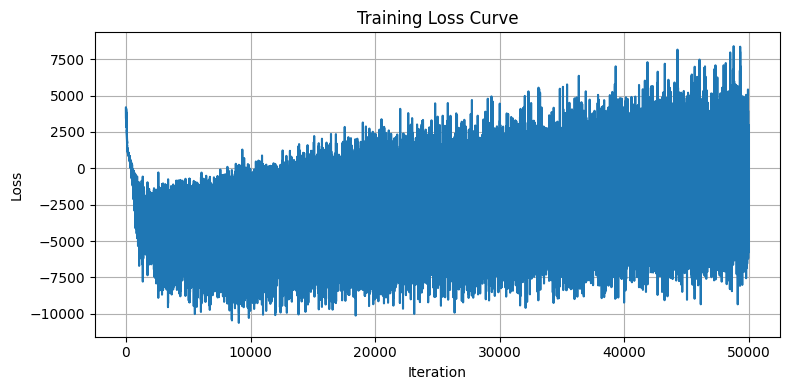

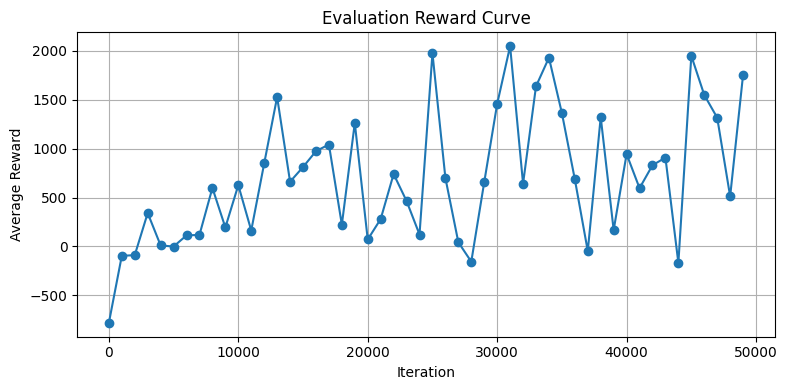

Final Average Cumulative Reward (from JSON): 773.74
Displaying rollout video: rl-video-episode-0.mp4


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from IPython.display import Video, display

def load_and_plot_results(save_dir: str, show_video: bool = True):
    """
    Load saved experiment results from `save_dir` and display/plot them.

    Expects the following files in `save_dir`:
      - loss_logs.npy
      - eval_reward_logs.npy
      - eval_rewards.csv
      - loss_curve.png      (optional)
      - reward_curve.png    (optional)
      - final_score.json
      - *.mp4               (rollout video)
    """
    # 1. Load NumPy arrays
    loss_logs = np.load(os.path.join(save_dir, "loss_logs.npy"))
    eval_reward_logs = np.load(os.path.join(save_dir, "eval_reward_logs.npy"))

    # 2. Load CSV (iteration vs eval reward)
    csv_path = os.path.join(save_dir, "eval_rewards.csv")
    if os.path.isfile(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # reconstruct if missing
        iterations = np.arange(0, len(eval_reward_logs) * eval_interval, eval_interval)
        df = pd.DataFrame({"iteration": iterations, "eval_reward": eval_reward_logs})

    # 3. Load final score
    final_score = None
    json_path = os.path.join(save_dir, "final_score.json")
    if os.path.isfile(json_path):
        with open(json_path, "r") as f:
            final_score = json.load(f).get("final_score")

    # 4. Plot training loss
    plt.figure(figsize=(8,4))
    plt.plot(loss_logs, label="Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Plot eval rewards from NumPy logs
    plt.figure(figsize=(8,4))
    iters = df["iteration"].values
    plt.plot(iters, df["eval_reward"].values, marker="o", label="Eval Reward")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.title("Evaluation Reward Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Print final score
    if final_score is not None:
        print(f"Final Average Cumulative Reward (from JSON): {final_score:.2f}")

    # 7. Display rollout video (if present)
    if show_video:
        # find first .mp4 in the directory
        mp4_files = [f for f in os.listdir(save_dir) if f.endswith(".mp4")]
        if mp4_files:
            video_path = os.path.join(save_dir, mp4_files[0])
            print(f"Displaying rollout video: {mp4_files[0]}")
            display(Video(video_path, embed=True, width=600, height=400))
        else:
            print("No .mp4 video found in", save_dir)

# Example usage:
# If you know the exact folder:
# load_and_plot_results("saved_results/hyperbolic_iql_20250413_153045")

# Or automatically pick the latest run under saved_results/
base_dir = "saved_results"
all_runs = sorted(
    [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
)
if all_runs:
    latest_run = all_runs[-1]
    print("Loading latest run:", latest_run)
    load_and_plot_results(os.path.join(base_dir, latest_run))
else:
    print("No saved_results directory or runs found.")
